In [1]:
# Clean uninstall first
!pip uninstall -y torch torchvision torchaudio

# Reinstall PyTorch, TorchVision, Torchaudio (CUDA 11.8 compatible)
!pip install torch==2.0.1+cu118 torchvision==0.15.2+cu118 torchaudio==2.0.2+cu118 --index-url https://download.pytorch.org/whl/cu118

Found existing installation: torch 2.6.0+cu124
Uninstalling torch-2.6.0+cu124:
  Successfully uninstalled torch-2.6.0+cu124
Found existing installation: torchvision 0.21.0+cu124
Uninstalling torchvision-0.21.0+cu124:
  Successfully uninstalled torchvision-0.21.0+cu124
Found existing installation: torchaudio 2.6.0+cu124
Uninstalling torchaudio-2.6.0+cu124:
  Successfully uninstalled torchaudio-2.6.0+cu124
Looking in indexes: https://download.pytorch.org/whl/cu118
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 GB 784.1 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.1/6.1 MB 105.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.4/4.4 MB 100.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.3/63.3 MB 11.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.3/132.3 kB 11.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lit: filename=lit-15.0.7-py3-none-any.whl size=89990 sha256=c66b106f68

In [3]:
!pip install pennylane

In [4]:
# 1) Install NumPy so that torch.Tensor.numpy() is actually available
!pip install numpy

# 2) Monkey-patch PennyLane to never call .numpy() on torch.Tensors,
#    avoiding the “Numpy is not available” error
import pennylane.math.single_dispatch as _sd
_sd._to_numpy_torch = lambda x: x.detach().cpu()

/usr/local/lib/python3.11/dist-packages/pennylane/capture/capture_operators.py:33: RuntimeWarning: PennyLane is not yet compatible with JAX versions > 0.4.28. You have version 0.5.2 installed. Please downgrade JAX to <=0.4.28 to avoid runtime errors.
  warnings.warn(


In [5]:
import os
import cv2
import torch
import numpy as np
from torch.utils.data import Dataset, DataLoader, random_split
import torchvision.transforms as T
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from tqdm import tqdm
import pennylane as qml
from pennylane import numpy as pnp
from pennylane.qnn import TorchLayer


A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.0.2 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "<frozen runpy>", line 198, in _run_module_as_main
  File "<frozen runpy>", line 88, in _run_code
  File "/usr/local/lib/python3.11/dist-packages/colab_kernel_launcher.py", line 37, in <module>
    ColabKernelApp.launch_instance()
  File "/usr/local/lib/python3.11/dist-packages/traitlets/config/application.py", line 992, in launch_instance
    app.start()
  File "/usr/local/lib/python3.11/dist-packages/ipykernel/kernelapp.py", line 712, in start
    self.io_loop.start()
  File "/usr/local/lib/python3.11/dist-package

In [6]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [7]:
fire_path = '/content/drive/MyDrive/ForestFireDataset/train/fire'
no_fire_path = '/content/drive/MyDrive/ForestFireDataset/train/nofire'

In [20]:
class FireDataset(Dataset):
    def __init__(self, fire_dir, no_fire_dir, transform=None):
        self.transform   = transform
        self.image_paths = []
        self.labels      = []

        def scan_dir(dir_path, label):
            for fn in os.listdir(dir_path):
                if not fn.lower().endswith(('.jpg', '.png', '.jpeg')):
                    continue
                full = os.path.join(dir_path, fn)
                # Try to load—if None, skip it
                if cv2.imread(full) is None:
                    print(f"Skipping unreadable image: {full}")
                    continue
                self.image_paths.append(full)
                self.labels.append(label)

        scan_dir(fire_dir,    label=1)  # collect only valid “fire” images
        scan_dir(no_fire_dir, label=0)  # collect only valid “no-fire” images

        if not self.image_paths:
            raise RuntimeError("No valid images found in the provided directories.")

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img = cv2.imread(self.image_paths[idx])  # guaranteed non-None
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (128, 128))
        if self.transform:
            img = self.transform(img)
        return img, self.labels[idx]


In [21]:
# Define a transform without using numpy (to_tensor_no_numpy_pil avoids np.array)
def to_tensor_no_numpy_pil(img):
    # Ensure input is PIL Image in RGB
    if img.mode != "RGB":
        img = img.convert("RGB")
    W, H = img.size
    # Convert image to raw bytes and then to a ByteTensor
    data = img.tobytes()
    tensor = torch.ByteTensor(torch.ByteStorage.from_buffer(data)).view(H, W, 3)
    tensor = tensor.permute(2, 0, 1).float().div(255.0)  # shape (3,H,W), scale [0,1]
    return tensor

# Compose training and validation transforms (data augmentation for training only)
train_transform = T.Compose([
    T.ToPILImage(),
    T.RandomHorizontalFlip(),
    T.RandomRotation(15),
    T.ColorJitter(brightness=0.2, contrast=0.2),
    T.Lambda(to_tensor_no_numpy_pil),  # convert to tensor without numpy
    T.Normalize(mean=[0.5]*3, std=[0.5]*3)
])
val_transform = T.Compose([
    T.ToPILImage(),
    T.Lambda(to_tensor_no_numpy_pil),
    T.Normalize(mean=[0.5]*3, std=[0.5]*3)
])


In [22]:
# Create the full dataset and split into train/validation subsets
full_dataset = FireDataset(fire_path, no_fire_path)
total_len = len(full_dataset)
val_len   = int(0.2 * total_len)       # 20% for validation
train_len = total_len - val_len        # 80% for training
train_subset, val_subset = random_split(full_dataset, [train_len, val_len])

# Wrap subsets to apply transforms
class WrappedDataset(Dataset):
    def __init__(self, subset, transform):
        self.subset = subset
        self.transform = transform
    def __len__(self):
        return len(self.subset)
    def __getitem__(self, idx):
        img, label = self.subset[idx]
        if self.transform:
            img = self.transform(img)
        return img, label

train_dataset = WrappedDataset(train_subset, transform=train_transform)
val_dataset   = WrappedDataset(val_subset,   transform=val_transform)

# DataLoader for training and validation
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=0, pin_memory=True)
val_loader   = DataLoader(val_dataset,   batch_size=16, shuffle=False, num_workers=0, pin_memory=True)

Skipping unreadable image: /content/drive/MyDrive/ForestFireDataset/train/nofire/0189.png
Skipping unreadable image: /content/drive/MyDrive/ForestFireDataset/train/nofire/rain141.jpg


CNN Feature Extractor
The core convolutional feature extractor is defined in the CNNFeatureExtractor class (lines 141–169). It consists of four convolutional blocks, each block including a convolution, batch normalization, ReLU activation, and a max pooling. The blocks are:
Conv Block 1: Conv2d from 3 input channels (RGB) to 32 channels, kernel 3×3, padding 1, followed by BN, ReLU, and MaxPool2d(2). This reduces spatial size from 128→64.
Conv Block 2: 32→64 channels, 3×3 conv, BN, ReLU, MaxPool (64→32).
Conv Block 3: 64→128 channels, same pattern, pool (32→16).
Conv Block 4: 128→256 channels, same pattern, pool (16→8).
Thus, after passing a 128×128 RGB image, the output feature map has 256 channels of size 8×8 (spatial dimensions halved at each pooling). The forward method (lines 169–174) simply applies these blocks in sequence. A quick dummy test (lines 175–179) shows that a random tensor of shape (1,3,128,128) yields an output of shape (1,256,8,8). This CNN serves as a classical feature extractor: it converts images into high-level convolutional features (256 channels) on which further processing (attention and quantum layers) can be applied.

In [24]:
# CNN feature extractor: 4 conv blocks -> 256 feature channels
class CNNFeatureExtractor(nn.Module):
    def __init__(self):
        super(CNNFeatureExtractor, self).__init__()
        self.conv_block_1 = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2)    # 128->64
        )
        self.conv_block_2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2)    # 64->32
        )
        self.conv_block_3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2)    # 32->16
        )
        self.conv_block_4 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(2)    # 16->8
        )
    def forward(self, x):
        x = self.conv_block_1(x)
        x = self.conv_block_2(x)
        x = self.conv_block_3(x)
        x = self.conv_block_4(x)
        return x
        # Instantiate and test with dummy input
model = CNNFeatureExtractor()
x = torch.randn(1, 3, 128, 128)  # batch of 1 RGB image of size 128x128
out = model(x)
print("Output shape:", out.shape)

Output shape: torch.Size([1, 256, 8, 8])


CBAM (Convolutional Block Attention Module)
To enhance the feature maps, the code implements a CBAM (Convolutional Block Attention Module) consisting of channel and spatial attention (lines 181–226). The ChannelAttention class (lines 181–197) computes a channel-wise attention vector. Given an input feature map of in_ch channels, it uses adaptive average pooling and max pooling to reduce each channel map to 1×1, passes these through a shared two-layer MLP (implemented as two 1×1 convolutions with a ReLU in between), and then sums the results and applies a sigmoid. Effectively, it learns weights for each channel. The SpatialAttention class (lines 199–214) computes a spatial attention map: it takes the input feature map, computes channel-wise mean and max (resulting in two H×W maps), concatenates them along the channel axis (2 channels total), and runs a 7×7 convolution and sigmoid. This produces a 1-channel H×W attention map. The CBAM class (lines 216–226) simply applies channel attention first (x = x * ca(x)) then spatial attention (x = x * sa(x)), so the feature map is refined by emphasizing important channels and spatial locations. This design follows the original CBAM proposal: “our module sequentially infers attention maps along two separate dimensions, channel and spatial, then … multiplies to the input feature map for adaptive feature refinement”
. In other words, CBAM re-weights the convolutional features to focus on the most informative parts of the image.

In [25]:
# Channel Attention submodule (for CBAM)
class ChannelAttention(nn.Module):
    def __init__(self, in_ch, reduction=16):
        super(ChannelAttention, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)  # output size (in_ch,1,1)
        self.max_pool = nn.AdaptiveMaxPool2d(1)
        self.fc = nn.Sequential(
            nn.Conv2d(in_ch, in_ch // reduction, kernel_size=1, bias=False),
            nn.ReLU(),
            nn.Conv2d(in_ch // reduction, in_ch, kernel_size=1, bias=False)
        )
        self.sigmoid = nn.Sigmoid()
    def forward(self, x):
        # Apply MLP to avg pooled and max pooled features, then sum
        avg_out = self.fc(self.avg_pool(x))
        max_out = self.fc(self.max_pool(x))
        return self.sigmoid(avg_out + max_out)

# Spatial Attention submodule (for CBAM)
class SpatialAttention(nn.Module):
    def __init__(self):
        super(SpatialAttention, self).__init__()
        # Convolutional layer that takes [avg_pool; max_pool] as input (2 channels)
        self.conv = nn.Conv2d(2, 1, kernel_size=7, padding=3, bias=False)
        self.sigmoid = nn.Sigmoid()
    def forward(self, x):
        # Compute channel-wise mean and max to form a 2-channel spatial map
        avg_channel = torch.mean(x, dim=1, keepdim=True)
        max_channel, _ = torch.max(x, dim=1, keepdim=True)
        # Concatenate and apply conv->sigmoid to get spatial attention map
        attn_map = self.sigmoid(self.conv(torch.cat([avg_channel, max_channel], dim=1)))
        return attn_map

# CBAM module combining Channel and Spatial attention
class CBAM(nn.Module):
    def __init__(self, in_channels):
        super(CBAM, self).__init__()
        self.ca = ChannelAttention(in_channels)
        self.sa = SpatialAttention()
    def forward(self, x):
        # Sequentially apply channel attention and spatial attention
        x = x * self.ca(x)  # refine feature map by channel attention
        x = x * self.sa(x)  # refine feature map by spatial attention
        return x

Quantum Circuits (Variational Blocks and Encodings)
The hybrid model uses a 4-qubit variational quantum circuit (lines 228–243). First, n_qubits = 4 and a PennyLane device is created (default.qubit with 4 wires). A variational_block function (lines 234–243) defines a parameterized subcircuit: for each qubit j, it applies rotations RX, RY, RZ with angles given by a weight tensor weights[j], and then entangles neighboring qubits with a chain of CNOTs (between qubit j and j+1). This block can be reused in different circuits. Two QNodes (quantum functions) are defined: circuit_angle (lines 245–253) and circuit_amplitude (lines 254–263). The @qml.qnode(dev, interface="torch") decorator makes them PyTorch-compatible quantum circuits.
Angle-Encoding Circuit (circuit_angle): It expects a 4-dimensional input vector (one value per qubit). For each qubit i, it applies qml.RY(inputs[i], wires=i), embedding the input as a rotation angle on the Y axis. Then it calls the shared variational_block(weights) with trainable weights, and finally returns the expectation value of Pauli-Z on each qubit. So its output is a 4-component vector of expectation values.
Amplitude-Encoding Circuit (circuit_amplitude): It expects a 16-dimensional input vector (for 4 qubits). It uses qml.AmplitudeEmbedding to load the 16 inputs into the quantum state amplitudes across the 4 qubits. (The code assumes the vector is already normalized and sets normalize=False.) It then applies the same variational_block(weights) and returns the 4 Pauli-Z expectations.
These circuits differ only in how classical data is fed into the quantum state: angle-encoding uses rotation gates per qubit, while amplitude-encoding uses amplitude embedding of a higher-dimensional vector. Both then apply trainable rotations and entanglement. The returned 4 expectation values serve as the quantum layer’s output features.

In [33]:
# Quantum device and circuit parameters
n_qubits = 4
dev = qml.device("default.qubit", wires=n_qubits)
# Shape of trainable circuit parameters: one (RX,RY,RZ) triplet per qubit
weight_shapes = {"weights": (n_qubits, 3)}

# Define a reusable variational block (rotation + entanglement) for the circuits
def variational_block(weights):
    # Parametrized single-qubit rotations
    for j in range(n_qubits):
        qml.RX(weights[j, 0], wires=j)
        qml.RY(weights[j, 1], wires=j)
        qml.RZ(weights[j, 2], wires=j)
    # Entangle neighboring qubits with CNOT chain
    for j in range(n_qubits - 1):
        qml.CNOT(wires=[j, j+1])

# Quantum circuit for Angle Encoding
@qml.qnode(dev, interface="torch")
def circuit_angle(inputs, weights):
    # inputs: 4-dimensional vector (one angle per qubit)
    for i in range(n_qubits):
        qml.RY(inputs[i], wires=i)
    variational_block(weights)
    return [qml.expval(qml.PauliZ(i)) for i in range(n_qubits)]

# Quantum circuit for Amplitude Encoding
@qml.qnode(dev, interface="torch")
def circuit_amplitude(inputs, weights):
    # inputs: 16-dimensional vector (amplitudes for 4 qubits)
    # Assume inputs is already normalized. Use validate_norm=False to skip norm check.
    qml.AmplitudeEmbedding(features=inputs, wires=range(n_qubits), normalize=False, pad_with=None, validate_norm=False)
    variational_block(weights)
    return [qml.expval(qml.PauliZ(i)) for i in range(n_qubits)]

Quantum Layer Integration
To use these QNodes inside a PyTorch model, the code wraps them with qml.qnn.TorchLayer. A weight_shapes dictionary is defined as {"weights": (4,3)} (lines 230–233), matching the (n_qubits, 3) shape of the variational block’s weights. Then TorchLayer(circuit_angle, weight_shapes) and similarly for circuit_amplitude create PyTorch-friendly layers (qlayer_angle and qlayer_amplitude). The TorchLayer class “converts a QNode to a Torch layer… which can be used within the torch.nn Sequential or Module classes for creating quantum and hybrid models”
docs.pennylane.ai
. In effect, each TorchLayer has its own weight tensor of shape (4,3) and, when given an input tensor, executes the quantum circuit and returns its outputs as a PyTorch tensor. The code collects these in a dictionary quantum_layers = {"angle": qlayer_angle, "amplitude": qlayer_amplitude} for easy access. (There is also a custom QuantumLayer class defined in lines 267–282 that manually wraps a QNode, but ultimately the code uses TorchLayer, making the custom class unnecessary.)

In [34]:
import torch.nn as nn

class QuantumLayer(nn.Module):
    def __init__(self, qnode, n_qubits):
        super().__init__()
        # same shape as your old TorchLayer weights
        self.weights = nn.Parameter(torch.randn(n_qubits, 3))
        self.qnode   = qnode

    def forward(self, inputs):
        # inputs: [batch_size, n_qubits]
        outs = []
        for i in range(inputs.shape[0]):
            # run each sample through the QNode with shared weights
            out = self.qnode(inputs[i], self.weights)
            outs.append(out)
        return torch.stack(outs, dim=0)  # [batch_size, n_qubits]

In [36]:
# Wrap each QNode in a TorchLayer for integration with PyTorch
from pennylane.qnn import TorchLayer
qlayer_angle     = TorchLayer(circuit_angle, weight_shapes)
qlayer_amplitude = TorchLayer(circuit_amplitude, weight_shapes)

# Dictionary to access the quantum layer by encoding name
quantum_layers = {
    "angle":     qlayer_angle,
    "amplitude": qlayer_amplitude
}

HybridQCNN Model (with CBAM)
The main model class HybridQCNN (lines 294–319) defines the hybrid network with the CBAM attention module. Its constructor takes an encoding argument (“angle” or “amplitude”) and asserts it is valid. It then creates:
self.cnn_feature = CNNFeatureExtractor(): the convolutional feature extractor described above.
self.attention = CBAM(in_channels=256): the CBAM module operating on 256-channel features.
self.global_pool = nn.AdaptiveAvgPool2d((1,1)): global average pooling to collapse spatial dimensions.
self.flatten = nn.Flatten(): to flatten the pooled features.
self.fc_reduce: a linear layer to reduce the 256 features to the right size for the quantum layer. If using amplitude encoding, it maps 256→16 (since 4 qubits require 16 amplitudes); for angle encoding, it maps 256→4 (one value per qubit).
self.quantum_layer: the TorchLayer corresponding to the chosen encoding (pulled from quantum_layers).
self.fc_output = nn.Linear(4, 2): a final linear layer that maps the 4 quantum outputs to 2 class logits (fire/no-fire).
The forward method (lines 320–350) processes a batch step by step:
CNN + Attention: Pass input x through cnn_feature, then through attention, yielding a tensor of shape [N,256,8,8].
Global Pooling: Apply global_pool to get [N,256,1,1], then flatten to [N,256].
Linear Reduction: Apply fc_reduce to get [N,16] or [N,4] depending on encoding.
Preparation for Quantum: If using amplitude encoding, normalize each sample vector to unit length (so it can be embedded as amplitudes). If angle encoding, no normalization is needed (these are interpreted as rotation angles). This yields x_prepared of shape [N,4] or [N,16].
Quantum Layer Execution: PennyLane’s default qubit simulator runs on CPU, so the code moves x_prepared to CPU. It then iterates over the batch, feeding each sample x_cpu[i] through self.quantum_layer (the TorchLayer), which returns a tensor of shape [4] (the 4 qubit expectations). The outputs are collected and moved back to the original device, stacked into x_q of shape [N,4].
Final Classification: Apply self.fc_output to x_q to produce [N,2] logits, and then F.log_softmax is applied to get log-probabilities for the two classes.
This design tightly couples the classical CNN features with a quantum layer. The CBAM attention refines the features before quantum encoding. The final output is suitable for an NLLLoss (negative log-likelihood) criterion.

In [44]:
# Hybrid Quantum-Classical CNN model (no more “basis” encoding)
class HybridQCNN(nn.Module):
    def __init__(self, encoding="angle"):
        super(HybridQCNN, self).__init__()
        assert encoding in ["angle", "amplitude"], "Encoding must be 'angle' or 'amplitude'"
        self.encoding    = encoding
        self.cnn_feature = CNNFeatureExtractor()
        self.attention   = CBAM(in_channels=256)
        self.global_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.flatten     = nn.Flatten()

        # Reduce to the proper number of features for the quantum layer
        if encoding == "amplitude":
            # 16 features for 4 qubits
            self.fc_reduce = nn.Linear(256, 2**n_qubits)
        else:  # angle encoding
            # 4 features for 4 qubits
            self.fc_reduce = nn.Linear(256, n_qubits)

        # Select the quantum layer for this encoding
        self.quantum_layer = quantum_layers[encoding]

        # Final classifier
        self.fc_output = nn.Linear(n_qubits, 2)

    def forward(self, x):
        # 1) CNN + CBAM feature extraction
        x = self.cnn_feature(x)                 # [N,256,8,8]
        x = self.attention(x)                   # [N,256,8,8]
        x = self.global_pool(x)                 # [N,256,1,1]
        x = self.flatten(x)                     # [N,256]

        # 2) Linear reduction
        x = self.fc_reduce(x)                   # [N,4] or [N,16]

        # 3) Prepare for quantum layer
        if self.encoding == "amplitude":
            # normalize to unit length for amplitude embedding
            norm = torch.norm(x, dim=1, keepdim=True)
            norm = torch.where(norm == 0, torch.ones_like(norm), norm)
            x_prepared = x / norm               # [N,16]
        else:  # angle encoding
            x_prepared = x                      # [N,4]

        # 4) Batch through quantum layer (on CPU)
        orig_dev = x_prepared.device
        x_cpu    = x_prepared.to("cpu")
        q_outs   = []
        for i in range(x_cpu.shape[0]):
            q_res = self.quantum_layer(x_cpu[i])   # returns [4]
            q_outs.append(q_res.to(orig_dev))
        x_q = torch.stack(q_outs, dim=0)           # [N,4]

        # 5) Final classification
        x_logits = self.fc_output(x_q)             # [N,2]
        return F.log_softmax(x_logits, dim=1)


In [45]:
# 6. Training Setup: device, loss, optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = HybridQCNN().to(device)
criterion = nn.NLLLoss()               # negative log-likelihood loss (for log-softmax outputs)
optimizer = optim.Adam(model.parameters(), lr=1e-4)


In [47]:
# Device configuration for training
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Loss function and evaluation metric
criterion = nn.NLLLoss()
def evaluate(model, loader):
    model.eval()
    correct = total = 0
    with torch.no_grad():
        for imgs, labels in loader:
            imgs, labels = imgs.to(device), labels.to(device)
            output = model(imgs)
            preds = torch.argmax(output, dim=1)
            correct += (preds == labels).sum().item()
            total   += labels.size(0)
    return 100 * correct / total

# Training loop for a given model
def train_model(model, train_loader, val_loader, epochs):
    model.to(device)
    optimizer = optim.Adam(model.parameters(), lr=1e-4)
    for epoch in range(1, epochs+1):
        model.train()
        running_loss = 0.0
        correct = total = 0
        for imgs, labels in train_loader:
            imgs, labels = imgs.to(device), labels.to(device)
            optimizer.zero_grad()
            out = model(imgs)                    # forward pass
            loss = criterion(out, labels)        # compute loss
            loss.backward()                      # backpropagate
            optimizer.step()                     # update parameters
            # accumulate training loss and accuracy
            running_loss += loss.item() * imgs.size(0)
            preds = torch.argmax(out, dim=1)
            correct += (preds == labels).sum().item()
            total   += labels.size(0)
        avg_loss = running_loss / total
        train_acc = 100 * correct / total
        val_acc   = evaluate(model, val_loader)
        print(f"Epoch {epoch}/{epochs} - Loss: {avg_loss:.4f} - Train Acc: {train_acc:.2f}% - Val Acc: {val_acc:.2f}%")

# Train and validate each encoding strategy
encodings = ["amplitude", "angle"]
results = {}
for enc in encodings:
    print(f"\n*** Training with {enc.upper()} encoding ***")
    model = HybridQCNN(encoding=enc)
    train_model(model, train_loader, val_loader, epochs=10)   # train for 10 epochs
    val_acc = evaluate(model, val_loader)
    results[enc] = val_acc

print("\nValidation accuracies by encoding:")
for enc, acc in results.items():
    print(f"  {enc}: {acc:.2f}%")



*** Training with AMPLITUDE encoding ***
Epoch 1/10 - Loss: 0.4792 - Train Acc: 85.57% - Val Acc: 91.85%
Epoch 2/10 - Loss: 0.4186 - Train Acc: 88.62% - Val Acc: 90.15%
Epoch 3/10 - Loss: 0.3897 - Train Acc: 89.86% - Val Acc: 93.55%
Epoch 4/10 - Loss: 0.3583 - Train Acc: 91.68% - Val Acc: 93.89%
Epoch 5/10 - Loss: 0.3316 - Train Acc: 92.70% - Val Acc: 94.74%
Epoch 6/10 - Loss: 0.3089 - Train Acc: 93.42% - Val Acc: 93.55%
Epoch 7/10 - Loss: 0.2865 - Train Acc: 94.06% - Val Acc: 95.59%
Epoch 8/10 - Loss: 0.2718 - Train Acc: 94.02% - Val Acc: 96.26%
Epoch 9/10 - Loss: 0.2426 - Train Acc: 95.08% - Val Acc: 97.62%
Epoch 10/10 - Loss: 0.2322 - Train Acc: 95.59% - Val Acc: 97.28%

*** Training with ANGLE encoding ***
Epoch 1/10 - Loss: 0.5671 - Train Acc: 73.73% - Val Acc: 87.10%
Epoch 2/10 - Loss: 0.4119 - Train Acc: 89.60% - Val Acc: 93.38%
Epoch 3/10 - Loss: 0.3666 - Train Acc: 92.06% - Val Acc: 95.08%
Epoch 4/10 - Loss: 0.3304 - Train Acc: 93.42% - Val Acc: 96.26%
Epoch 5/10 - Loss: 0.29

In [48]:
# 1) Define a version of HybridQCNN *without* the CBAM attention block

class HybridQCNNNoAttn(nn.Module):
    def __init__(self, encoding="angle"):
        super(HybridQCNNNoAttn, self).__init__()
        assert encoding in ["angle", "amplitude"], "Must be 'angle' or 'amplitude'"
        self.encoding    = encoding

        # --- no CBAM here, just the CNN feature extractor ---
        self.cnn_feature = CNNFeatureExtractor()
        self.global_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.flatten     = nn.Flatten()

        # reduce to 4 angles or 16 amplitudes
        if encoding == "amplitude":
            self.fc_reduce = nn.Linear(256, 2**n_qubits)   # →16
        else:
            self.fc_reduce = nn.Linear(256, n_qubits)      # →4

        # pick the quantum layer
        self.quantum_layer = quantum_layers[encoding]

        # final classifier
        self.fc_output = nn.Linear(n_qubits, 2)

    def forward(self, x):
        # 1) CNN features (no attention)
        x = self.cnn_feature(x)         # [N,256,8,8]
        x = self.global_pool(x)         # [N,256,1,1]
        x = self.flatten(x)             # [N,256]

        # 2) reduce dimension
        x = self.fc_reduce(x)           # [N,4] or [N,16]

        # 3) prepare for quantum circuit
        if self.encoding == "amplitude":
            norm = torch.norm(x, dim=1, keepdim=True)
            norm = torch.where(norm == 0, torch.ones_like(norm), norm)
            x_prepared = x / norm
        else:
            x_prepared = x              # angles

        # 4) batch through quantum layer on CPU
        orig_dev = x_prepared.device
        x_cpu    = x_prepared.to("cpu")
        outs     = []
        for i in range(x_cpu.size(0)):
            q_out = self.quantum_layer(x_cpu[i])  # [4] expectations
            outs.append(q_out.to(orig_dev))
        x_q = torch.stack(outs, dim=0)           # [N,4]

        # 5) classification
        logits = self.fc_output(x_q)             # [N,2]
        return F.log_softmax(logits, dim=1)

# 2) Train both angle and amplitude models *without* CBAM
print("\n=== Training WITHOUT CBAM attention ===")
results_noattn = {}
for enc in ["angle", "amplitude"]:
    print(f"\n--- {enc.upper()} encoding (No CBAM) ---")
    model_noattn = HybridQCNNNoAttn(encoding=enc).to(device)
    train_model(model_noattn, train_loader, val_loader, epochs=10)
    results_noattn[enc] = evaluate(model_noattn, val_loader)

print("\nValidation accuracies WITHOUT CBAM:")
for enc, acc in results_noattn.items():
    print(f"  {enc}: {acc:.2f}%")



=== Training WITHOUT CBAM attention ===

--- ANGLE encoding (No CBAM) ---
Epoch 1/10 - Loss: 0.5369 - Train Acc: 80.86% - Val Acc: 89.64%
Epoch 2/10 - Loss: 0.4592 - Train Acc: 87.52% - Val Acc: 88.79%
Epoch 3/10 - Loss: 0.4274 - Train Acc: 88.79% - Val Acc: 93.21%
Epoch 4/10 - Loss: 0.4021 - Train Acc: 89.35% - Val Acc: 92.53%
Epoch 5/10 - Loss: 0.3694 - Train Acc: 90.62% - Val Acc: 95.42%
Epoch 6/10 - Loss: 0.3481 - Train Acc: 91.21% - Val Acc: 93.38%
Epoch 7/10 - Loss: 0.3311 - Train Acc: 91.81% - Val Acc: 94.57%
Epoch 8/10 - Loss: 0.3125 - Train Acc: 91.89% - Val Acc: 95.42%
Epoch 9/10 - Loss: 0.2955 - Train Acc: 92.61% - Val Acc: 95.59%
Epoch 10/10 - Loss: 0.2776 - Train Acc: 93.68% - Val Acc: 95.76%

--- AMPLITUDE encoding (No CBAM) ---
Epoch 1/10 - Loss: 0.4262 - Train Acc: 85.36% - Val Acc: 91.68%
Epoch 2/10 - Loss: 0.3494 - Train Acc: 89.47% - Val Acc: 92.19%
Epoch 3/10 - Loss: 0.3306 - Train Acc: 90.24% - Val Acc: 92.70%
Epoch 4/10 - Loss: 0.3283 - Train Acc: 89.35% - Val Ac


=== Training ANGLE + CBAM ===
HybridQCNN Ep1/10 — Loss: 0.4624, TrainAcc: 82.51%, ValAcc: 91.00%
HybridQCNN Ep2/10 — Loss: 0.3375, TrainAcc: 88.79%, ValAcc: 91.85%
HybridQCNN Ep3/10 — Loss: 0.3006, TrainAcc: 91.13%, ValAcc: 94.74%
HybridQCNN Ep4/10 — Loss: 0.2541, TrainAcc: 93.38%, ValAcc: 96.26%
HybridQCNN Ep5/10 — Loss: 0.2251, TrainAcc: 94.74%, ValAcc: 96.26%
HybridQCNN Ep6/10 — Loss: 0.2098, TrainAcc: 94.69%, ValAcc: 97.45%
HybridQCNN Ep7/10 — Loss: 0.1916, TrainAcc: 95.37%, ValAcc: 97.11%
HybridQCNN Ep8/10 — Loss: 0.1762, TrainAcc: 95.59%, ValAcc: 97.96%
HybridQCNN Ep9/10 — Loss: 0.1703, TrainAcc: 95.97%, ValAcc: 97.79%
HybridQCNN Ep10/10 — Loss: 0.1480, TrainAcc: 96.60%, ValAcc: 97.96%

=== Training AMPLITUDE + CBAM ===
HybridQCNN Ep1/10 — Loss: 0.4068, TrainAcc: 85.99%, ValAcc: 93.21%
HybridQCNN Ep2/10 — Loss: 0.3438, TrainAcc: 89.64%, ValAcc: 89.30%
HybridQCNN Ep3/10 — Loss: 0.3113, TrainAcc: 91.00%, ValAcc: 94.40%
HybridQCNN Ep4/10 — Loss: 0.2883, TrainAcc: 91.94%, ValAcc: 95

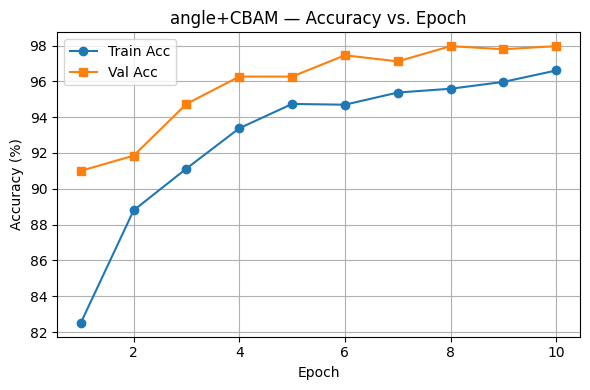

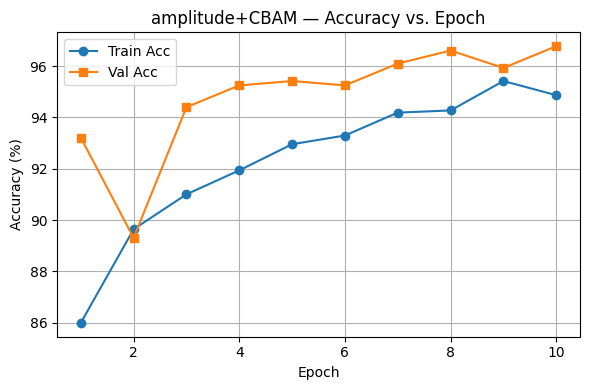

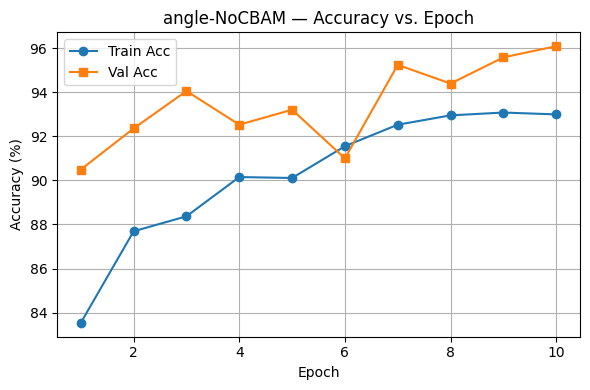

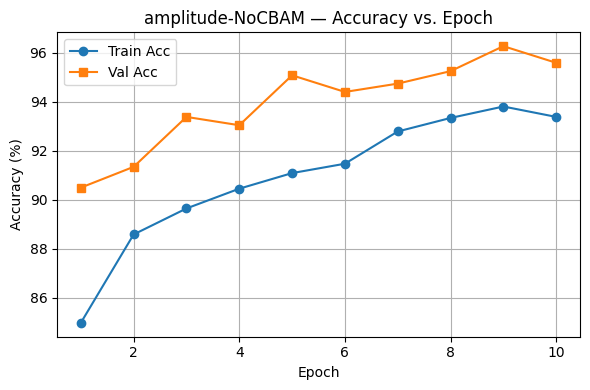

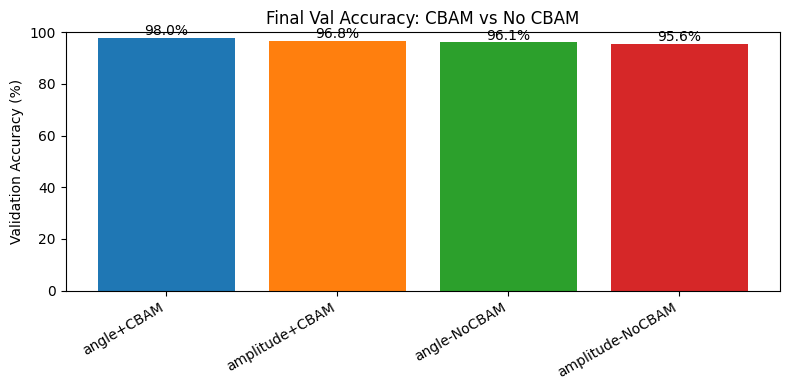

RuntimeError: Numpy is not available

In [69]:
import torch
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# 1) Helper to train and record metrics
def train_model_record(model, train_loader, val_loader, epochs=10):
    model.to(device)
    optimizer = optim.Adam(model.parameters(), lr=1e-4)
    loss_hist, train_acc_hist, val_acc_hist = [], [], []

    for ep in range(1, epochs + 1):
        model.train()
        running_loss = correct = total = 0
        for imgs, labels in train_loader:
            imgs, labels = imgs.to(device), labels.to(device)
            optimizer.zero_grad()
            out = model(imgs)
            loss = F.nll_loss(out, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * imgs.size(0)
            preds = out.argmax(1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
        avg_loss = running_loss / total
        train_acc = 100 * correct / total
        val_acc   = evaluate(model, val_loader)

        loss_hist.append(avg_loss)
        train_acc_hist.append(train_acc)
        val_acc_hist.append(val_acc)

        print(f"{type(model).__name__} Ep{ep}/{epochs} — Loss: {avg_loss:.4f}, TrainAcc: {train_acc:.2f}%, ValAcc: {val_acc:.2f}%")

    return loss_hist, train_acc_hist, val_acc_hist, model

# 2) Dictionaries to hold metrics & models
histories      = {}
trained_models = {}
final_acc      = {}

# 3) Train with CBAM: angle & amplitude
for enc in ["angle", "amplitude"]:
    print(f"\n=== Training {enc.upper()} + CBAM ===")
    m = HybridQCNN(encoding=enc).to(device)
    loss_h, tr_h, val_h, m = train_model_record(m, train_loader, val_loader, epochs=10)
    key = f"{enc}+CBAM"
    histories[key]      = {"loss": loss_h, "train_acc": tr_h, "val_acc": val_h}
    trained_models[key] = m
    final_acc[key]      = val_h[-1]

# 4) Train without CBAM
for enc in ["angle", "amplitude"]:
    print(f"\n=== Training {enc.upper()} - NoCBAM ===")
    m = HybridQCNNNoAttn(encoding=enc).to(device)
    loss_h, tr_h, val_h, m = train_model_record(m, train_loader, val_loader, epochs=10)
    key = f"{enc}-NoCBAM"
    histories[key]      = {"loss": loss_h, "train_acc": tr_h, "val_acc": val_h}
    trained_models[key] = m
    final_acc[key]      = val_h[-1]

# 5) Plot training & validation accuracy curves
for key, h in histories.items():
    epochs = list(range(1, len(h["train_acc"]) + 1))
    plt.figure(figsize=(6,4))
    plt.plot(epochs, h["train_acc"], 'o-', label="Train Acc")
    plt.plot(epochs, h["val_acc"],   's-', label="Val Acc")
    plt.title(f"{key} — Accuracy vs. Epoch")
    plt.xlabel("Epoch"); plt.ylabel("Accuracy (%)")
    plt.legend(); plt.grid(True)
    plt.tight_layout()
    plt.savefig(f"{key.replace('+','plus').replace('-','minus')}_acc_curve.png")
    plt.show()

# 6) Final validation accuracy comparison bar chart
labels = list(final_acc.keys())
values = list(final_acc.values())
plt.figure(figsize=(8,4))
bars = plt.bar(labels, values, color=["C0","C1","C2","C3"])
plt.ylabel("Validation Accuracy (%)")
plt.title("Final Val Accuracy: CBAM vs No CBAM")
plt.ylim(0,100)
for bar, v in zip(bars, values):
    plt.text(bar.get_x()+bar.get_width()/2, v+1, f"{v:.1f}%", ha="center")
plt.xticks(rotation=30, ha="right")
plt.tight_layout()
plt.savefig("final_val_accuracy_comparison.png")
plt.show()


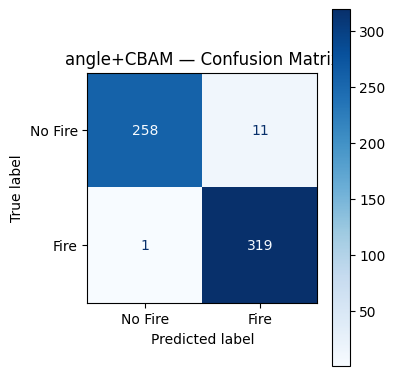

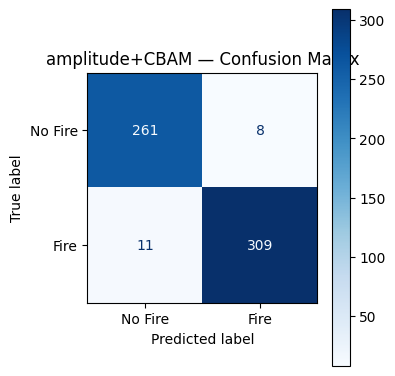

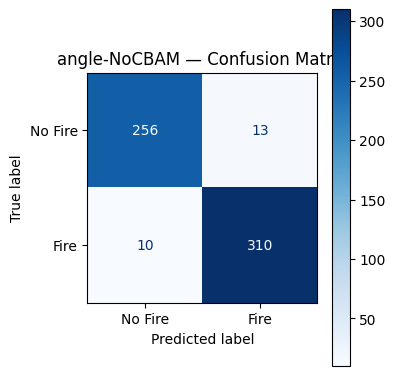

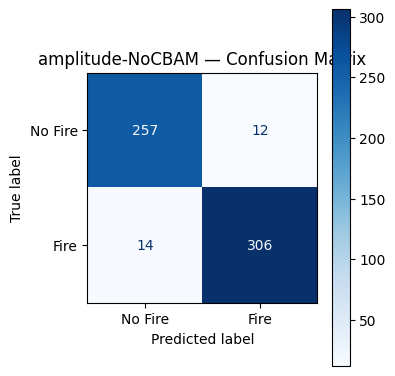

In [72]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import torch

# Assumes: trained_models dict, val_loader, device

for name, model in trained_models.items():
    model.eval()
    y_true, y_pred = [], []
    with torch.no_grad():
        for imgs, labels in val_loader:
            imgs = imgs.to(device)
            logits = model(imgs)
            # use .tolist() instead of .numpy()
            preds = logits.argmax(dim=1).cpu().tolist()
            labs  = labels.tolist()
            y_pred.extend(preds)
            y_true.extend(labs)

    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(cm, display_labels=["No Fire", "Fire"])
    fig, ax = plt.subplots(figsize=(4,4))
    disp.plot(ax=ax, cmap="Blues")
    ax.set_title(f"{name} — Confusion Matrix")
    plt.tight_layout()
    plt.show()


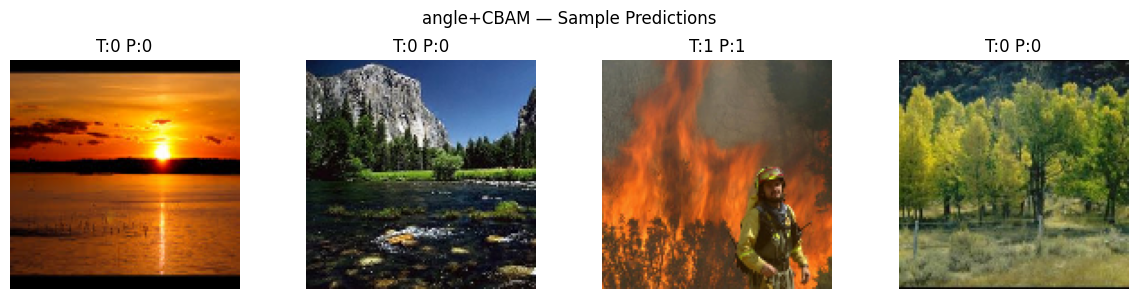

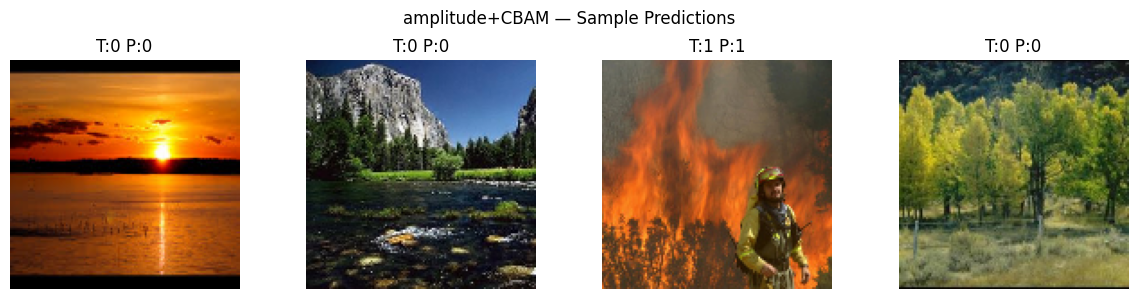

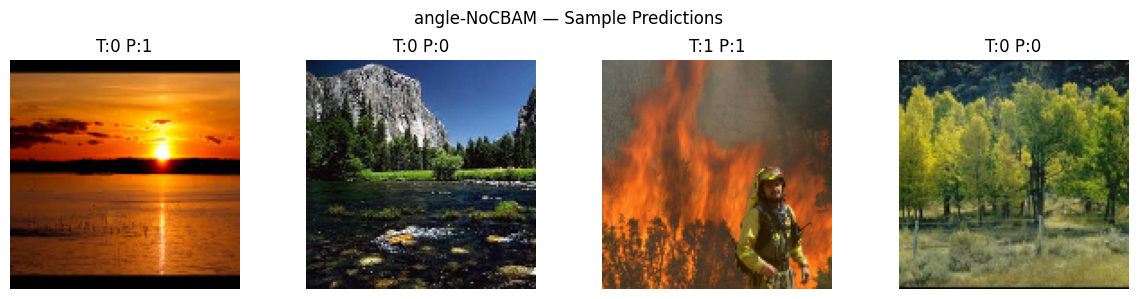

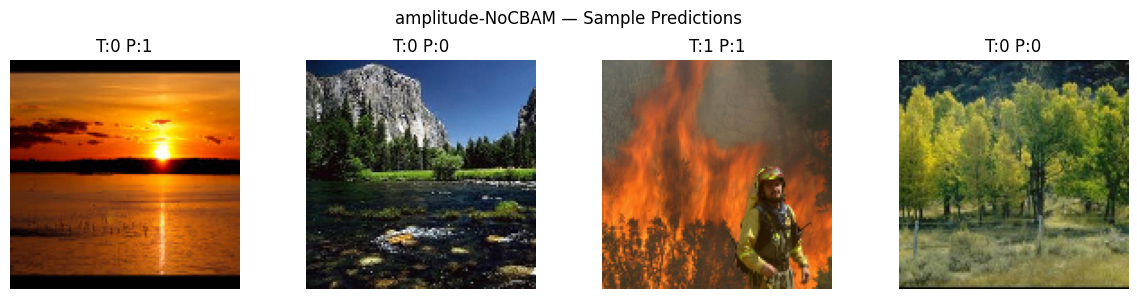

In [76]:
# 2) Show 4 sample predictions per model (avoid numpy by converting to Python lists)
for name, model in trained_models.items():
    model.eval()
    imgs, labels = next(iter(val_loader))
    logits = model(imgs.to(device))
    preds  = logits.argmax(dim=1).cpu().tolist()

    # un-normalize
    imgs_disp = imgs * 0.5 + 0.5

    fig, axes = plt.subplots(1, 4, figsize=(12, 3))
    for i, ax in enumerate(axes):
        # Convert to a nested Python list of RGB tuples
        tensor_byte = (imgs_disp[i] * 255).clamp(0,255).to(torch.uint8)  # [3,H,W]
        hwc = tensor_byte.permute(1,2,0)                                  # [H,W,3]
        img_list = hwc.tolist()                                          # Python list
        ax.imshow(img_list)
        ax.axis("off")
        ax.set_title(f"T:{labels[i].item()} P:{preds[i]}")
    plt.suptitle(f"{name} — Sample Predictions")
    plt.tight_layout()
    plt.show()

In [77]:
from sklearn.metrics import classification_report

# Pick one model to inspect, e.g. angle+CBAM
model = trained_models["angle+CBAM"]
model.eval()

# Collect all true & predicted labels
y_true, y_pred = [], []
with torch.no_grad():
    for imgs, labels in val_loader:
        logits = model(imgs.to(device))
        preds  = logits.argmax(dim=1).cpu().tolist()
        y_pred.extend(preds)
        y_true.extend(labels.tolist())

print(classification_report(y_true, y_pred, target_names=["No Fire","Fire"]))


              precision    recall  f1-score   support

     No Fire       1.00      0.96      0.98       269
        Fire       0.97      1.00      0.98       320

    accuracy                           0.98       589
   macro avg       0.98      0.98      0.98       589
weighted avg       0.98      0.98      0.98       589



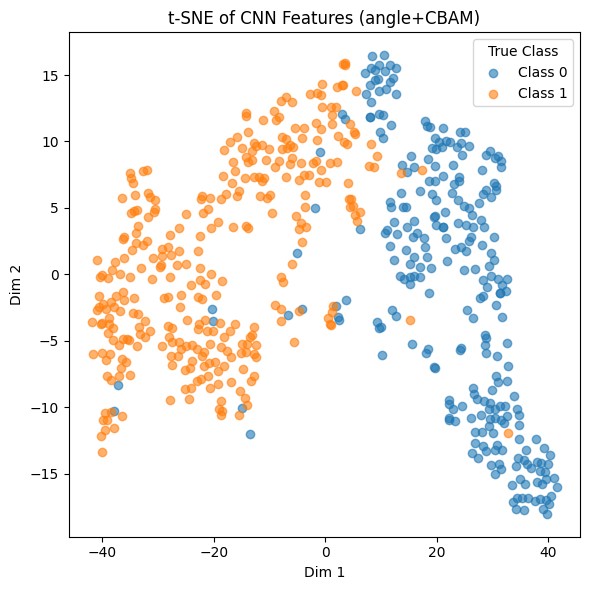

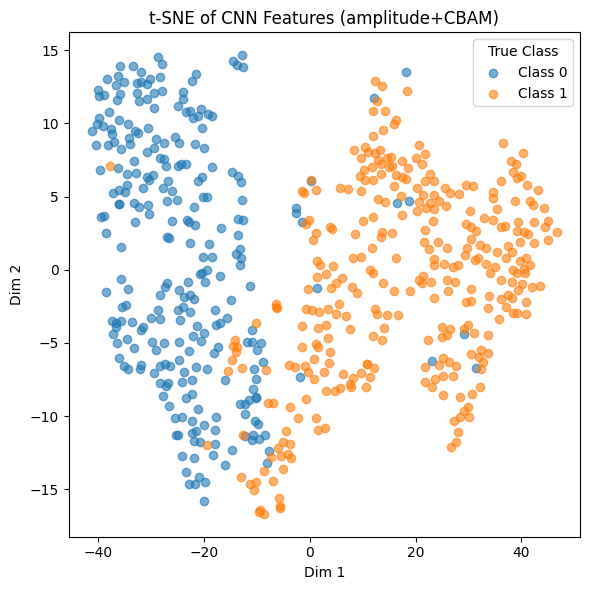

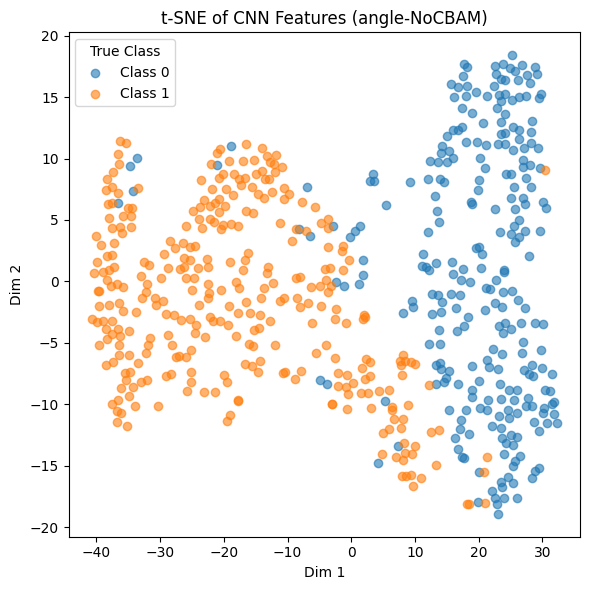

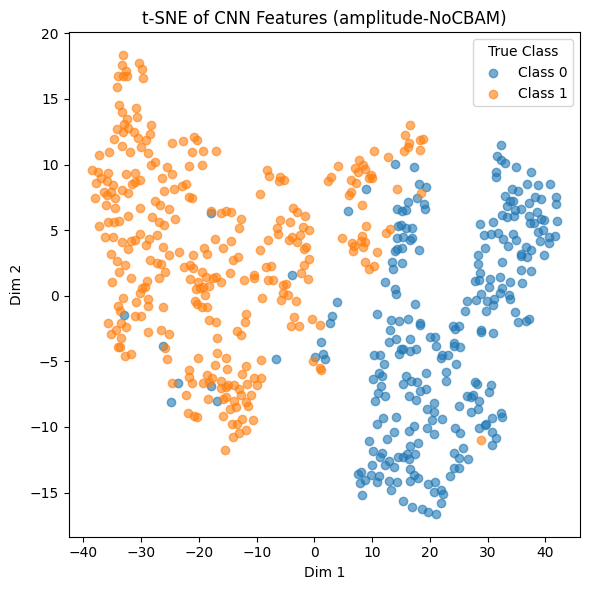

In [80]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

# Assumes you have:
# • trained_models: dict mapping names like "angle+CBAM", "angle-NoCBAM", "amplitude+CBAM", "amplitude-NoCBAM" → trained nn.Modules
# • val_loader, device already defined

for key, model in trained_models.items():
    # 1) Extract CNN features + labels over the entire validation set
    model.eval()
    feats, labs = [], []
    with torch.no_grad():
        for imgs, labels in val_loader:
            imgs = imgs.to(device)
            # get features *before* reduction & quantum layer:
            x = model.cnn_feature(imgs)                        # [B,256,H,W]
            x = model.global_pool(x).view(imgs.size(0), -1)    # [B,256]
            feats.extend(x.cpu().tolist())
            labs .extend(labels.tolist())

    # 2) Convert to NumPy arrays for TSNE
    feats_arr = np.array(feats)    # shape (N,256)
    labs_arr  = np.array(labs)     # shape (N,)

    # 3) Run t-SNE
    tsne = TSNE(n_components=2, random_state=0)
    proj = tsne.fit_transform(feats_arr)  # shape (N,2)

    # 4) Scatter plot, colored by true class
    plt.figure(figsize=(6,6))
    for cls in [0,1]:
        idx = (labs_arr == cls)
        plt.scatter(proj[idx,0], proj[idx,1], label=f"Class {cls}", alpha=0.6)
    plt.legend(title="True Class")
    plt.title(f"t-SNE of CNN Features ({key})")
    plt.xlabel("Dim 1"); plt.ylabel("Dim 2")
    plt.tight_layout()
    plt.savefig(f"tsne_{key.replace('+','plus').replace('-','minus')}.png")
    plt.show()


The only “structural” difference between the two diagrams is right at the very beginning—in how you load your classical data into the qubits.

Amplitude-Encoding Circuit

You see a big box labeled “|ψ⟩.” That is Pennylane’s AmplitudeEmbedding step, which takes your 16-component feature vector, normalizes (or pads) it, and dumps it all at once into the 4-qubit amplitudes.

After that, the variational block (RX→RY→RZ on each wire, followed by the same CNOT chain) is identical to the other circuit.

Angle-Encoding Circuit

Instead of one big amplitude loader, you have four independent RY gates up front—one per qubit—each rotating by the corresponding feature value.

Then you run the exact same RX→RY→RZ variational rotations and CNOT entanglers as in the amplitude version.

In other words, everything after the first block is the same—the only difference is whether you encode your data by (a) setting the entire multi-qubit amplitude vector at once, or (b) encoding each scalar feature as a single-qubit rotation angle.

Angle Encoding Circuit:
0: ──RY(0.00)──RX(0.00)──RY(0.00)──RZ(0.00)─╭●───────┤  <Z>
1: ──RY(0.00)──RX(0.00)──RY(0.00)──RZ(0.00)─╰X─╭●────┤  <Z>
2: ──RY(0.00)──RX(0.00)──RY(0.00)──RZ(0.00)────╰X─╭●─┤  <Z>
3: ──RY(0.00)──RX(0.00)──RY(0.00)──RZ(0.00)───────╰X─┤  <Z>


<ipython-input-88-2365ca91d3cf>:19: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


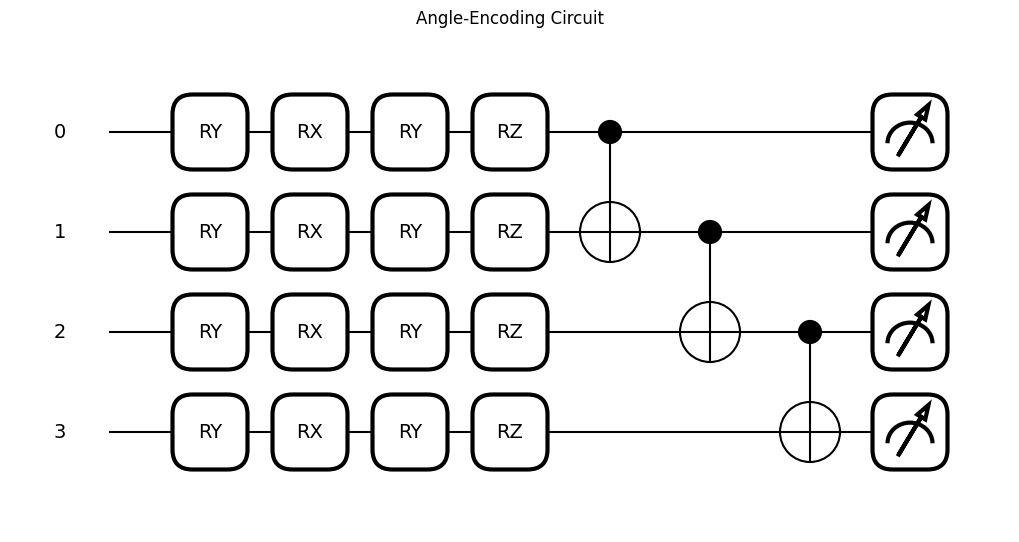

Amplitude Encoding Circuit:
0: ─╭|Ψ⟩──RX(0.00)──RY(0.00)──RZ(0.00)─╭●───────┤  <Z>
1: ─├|Ψ⟩──RX(0.00)──RY(0.00)──RZ(0.00)─╰X─╭●────┤  <Z>
2: ─├|Ψ⟩──RX(0.00)──RY(0.00)──RZ(0.00)────╰X─╭●─┤  <Z>
3: ─╰|Ψ⟩──RX(0.00)──RY(0.00)──RZ(0.00)───────╰X─┤  <Z>


<ipython-input-88-2365ca91d3cf>:29: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


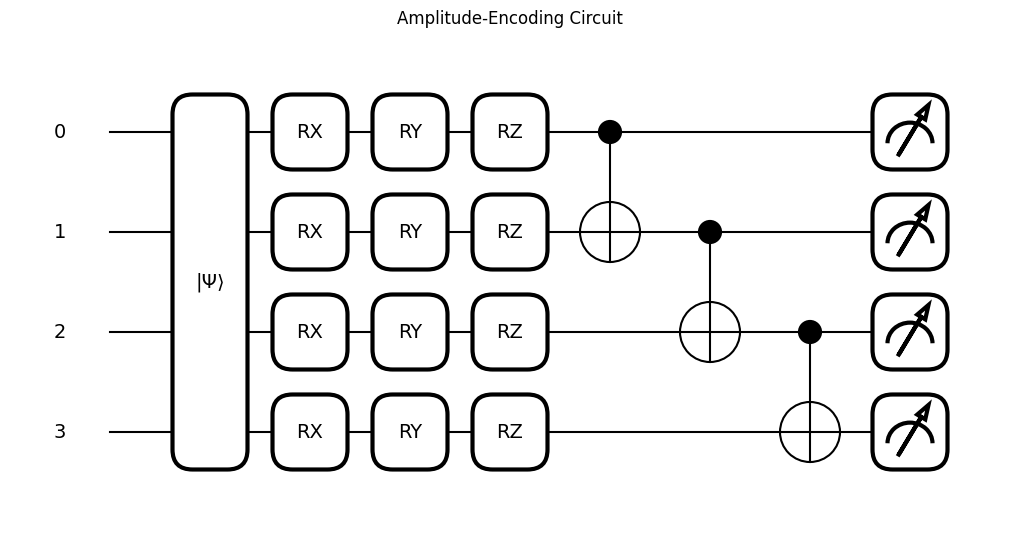

In [88]:
# Number of qubits
n_qubits = 4

# 1) Prepare purely PennyLane‐numpy inputs
#    - Angle encoding: 4 angles
x_angle = pnp.zeros(n_qubits)           # shape (4,)
#    - Amplitude encoding: 16 amplitudes
x_amp   = pnp.zeros(2**n_qubits)        # shape (16,)
#    - Shared weight tensor: (4 qubits × 3 rotations)
w       = pnp.zeros((n_qubits, 3))      # shape (4,3)

# 2) ASCII diagram for angle encoding
print("Angle Encoding Circuit:")
print(qml.draw(circuit_angle)(x_angle, w))

# 3) MPL plot for angle encoding
fig, ax = qml.draw_mpl(circuit_angle)(x_angle, w)
ax.set_title("Angle-Encoding Circuit")
plt.tight_layout()
plt.show()

# 4) ASCII diagram for amplitude encoding
print("Amplitude Encoding Circuit:")
print(qml.draw(circuit_amplitude)(x_amp, w))

# 5) MPL plot for amplitude encoding
fig, ax = qml.draw_mpl(circuit_amplitude)(x_amp, w)
ax.set_title("Amplitude-Encoding Circuit")
plt.tight_layout()
plt.show()